<a href="https://colab.research.google.com/github/Gaussiandra/bdimo21/blob/main/new15_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# reg
# 0 как таргеты
# балансировка
# больше агригаций

In [1]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          26124         574       23654           0        1896       25186
Swap:             0           0           0


In [2]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import os
import sys
import numpy as np
import pandas as pd
import sklearn
import numpy as np
import lightgbm
from sklearn.model_selection import train_test_split
import joblib
import scipy as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.linear_model import LogisticRegression, Ridge, RidgeClassifier
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
import seaborn as sns
from tqdm.auto import tqdm
sns.set()

In [5]:
sys.path.append('/content/drive/MyDrive/ML/bdimo21/')

In [6]:
!pip install catboost

     |████████████████████████████████| 65.7MB 58kB/s 


In [7]:
import submission
import importlib
importlib.reload(submission)

<module 'submission' from '/content/drive/MyDrive/ML/bdimo21/submission.py'>

In [8]:
import catboost

In [9]:
global_path = '/content/drive/MyDrive/ML/bdimo21/'

In [10]:
rheed_long = pd.read_csv(global_path+"ONTI_Dataset_parsed.csv", parse_dates=[6])
ma_coolness = rheed_long['Coolness_RHEED'].rolling(50).mean()
rheed_long['target'] = abs(ma_coolness-ma_coolness.shift(-435))

In [11]:
df = submission.preprocess(rheed_long, is_train=True)

In [12]:
#joblib.dump(df, global_path+'df.pkl')  

In [13]:
X = df.iloc[:-435]
y = (rheed_long['target'].iloc[3500:-435]>5)*1

In [14]:
y[ma_coolness.shift(-435) == 0] = 1

In [15]:
y.value_counts()

0    2241000
1     118837
Name: target, dtype: int64

In [16]:
ratio = 5
y_sampled = pd.concat((y[y==0].sample(y.value_counts()[1]*ratio, replace=False, random_state=0),
                       y[y==1]), axis=0)
X_sampled = X.loc[y_sampled.index]

#X_train, X_val, y_train, y_val = train_test_split(X_sampled, y_sampled, test_size=0.25, shuffle=True, stratify=y_sampled, random_state=0)
model = catboost.CatBoostClassifier(
    iterations=1000,
    #task_type="GPU",
    eval_metric='AUC',
    verbose=50
)
model.fit(X_sampled, y_sampled)#, eval_set=(X_val, y_val))

Learning rate set to 0.170298
0:	total: 635ms	remaining: 10m 34s
50:	total: 31.2s	remaining: 9m 40s
100:	total: 1m	remaining: 9m 1s
150:	total: 1m 31s	remaining: 8m 31s
200:	total: 2m 1s	remaining: 8m 2s
250:	total: 2m 30s	remaining: 7m 27s
300:	total: 3m 1s	remaining: 7m
350:	total: 3m 30s	remaining: 6m 28s
400:	total: 4m	remaining: 5m 58s
450:	total: 4m 28s	remaining: 5m 27s
500:	total: 4m 56s	remaining: 4m 55s
550:	total: 5m 26s	remaining: 4m 25s
600:	total: 5m 55s	remaining: 3m 56s
650:	total: 6m 24s	remaining: 3m 26s
700:	total: 6m 53s	remaining: 2m 56s
750:	total: 7m 23s	remaining: 2m 26s
800:	total: 7m 51s	remaining: 1m 57s
850:	total: 8m 20s	remaining: 1m 27s
900:	total: 8m 48s	remaining: 58.1s
950:	total: 9m 17s	remaining: 28.7s
999:	total: 9m 46s	remaining: 0us


In [17]:
with open(global_path+'model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
sklearn.metrics.plot_confusion_matrix(model, X_train, y_train, normalize='all')  # doctest: +SKIP
plt.show()  # doctest: +SKIP

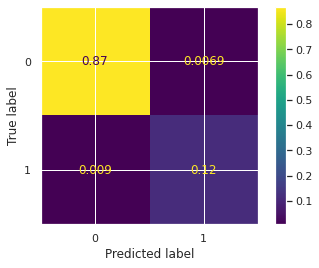

In [54]:
sklearn.metrics.plot_confusion_matrix(model, X_val, y_val,normalize='all')  # doctest: +SKIP
plt.show()  # doctest: +SKIP

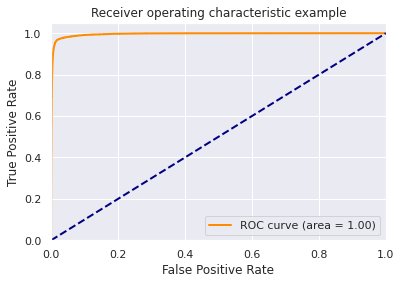

In [55]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_val, model.predict_proba(X_val)[:,1])
roc_auc = sklearn.metrics.roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
plt.figure()
lw = 2
plt.plot(fpr, tpr,color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

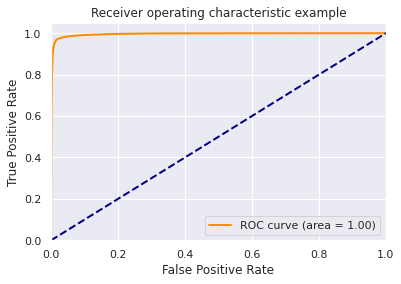

In [56]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_train, model.predict_proba(X_train)[:,1])
roc_auc = sklearn.metrics.roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
plt.figure()
lw = 2
plt.plot(fpr, tpr,color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [28]:
model.get_feature_importance(prettified=True)[:50]

,Feature Id,Importances
0,Displayed Rate_std_1000,3.756321
1,Y FWHM_RHEED_std_1000,3.240630
2,Coolness_RHEED_mean_50,3.180054
3,Coolness_RHEED_std_1000,2.869192
4,Source Power_std_1000,2.357032
5,R FWHM_RHEED_std_1000,2.156079
6,X FWHM_RHEED_std_1000,2.126598
7,Crystal Position_std_500,1.688467
8,Speed_RHEED_std_1000,1.673478
9,Raw Rate_std_1000,1.547379


In [23]:
pr = submission.Predictor()

In [24]:
pr.forecast(rheed_long.iloc[-10000:])

0.0001667871186037833